In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime,timedelta

In [2]:
%matplotlib inline

df_listings_bos = pd.read_csv('./boston/listings.csv')

df_listings_sea = pd.read_csv('./seattle/listings.csv')

In [3]:
df_listings_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [4]:
def clean_data(df):
    
    
    
    #columns related to host
    host_columns = ['price', 'host_name', 'host_since', 'host_location','host_about',
                    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                    'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications',
                    'host_has_profile_pic', 'host_identity_verified'
                   ]
    #columns related to review
    review_columns = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value']
    
    df = df[host_columns + review_columns].copy()
    
    
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    
    df['host_response_rate'] = df['host_response_rate'].map(lambda r: str(r).replace('%','')).astype("float")
    df['host_acceptance_rate'] = df['host_acceptance_rate'].map(lambda r: str(r).replace('%','')).astype("float")
    
    # Drop the rows without review since we are analysis reviews
    df.dropna(subset=review_columns, inplace=True)

    
    # Convert t/f into binary True/False
    df["host_is_superhost"]=df["host_is_superhost"].apply(lambda x:True if x=="t" else False)
    df["host_has_profile_pic"]=df["host_has_profile_pic"].apply(lambda x:True if x=="t" else False)
    df["host_identity_verified"]=df["host_identity_verified"].apply(lambda x:True if x=="t" else False)
    
    # For simplicity we only want to know if the host fill in the about section
    df["host_about"]= df["host_about"].fillna(False)
    df["host_about_exist"]=df["host_about"].apply(lambda x:True if x else False)
    
    

    # Convert string to datetime
    df["host_since"] = pd.to_datetime(df["host_since"])
    
    
    # Created host_for_days and get the number of days till now after host created account
    today = pd.to_datetime(datetime.now())
    result = today - df["host_since"]
    df["host_for_days"] = result.apply(lambda x: x.days)
    
    
    df.drop(columns=["host_about", "host_since"], inplace=True)
    
    # Drop the rows without bathroom, bedroom, host_location ,bed and property_type since they only have very few missing value
    df.dropna(subset=["host_location", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_neighbourhood"], inplace=True)
    
    return df

df_listings_bos = clean_data(df_listings_bos)
df_listings_sea = clean_data(df_listings_sea)

In [5]:
df_listings_bos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 1 to 3583
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        2312 non-null   float64
 1   host_name                    2312 non-null   object 
 2   host_location                2312 non-null   object 
 3   host_response_time           2312 non-null   object 
 4   host_response_rate           2312 non-null   float64
 5   host_acceptance_rate         2312 non-null   float64
 6   host_is_superhost            2312 non-null   bool   
 7   host_neighbourhood           2312 non-null   object 
 8   host_listings_count          2312 non-null   int64  
 9   host_total_listings_count    2312 non-null   int64  
 10  host_verifications           2312 non-null   object 
 11  host_has_profile_pic         2312 non-null   bool   
 12  host_identity_verified       2312 non-null   bool   
 13  number_of_reviews 

In [6]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2517 entries, 0 to 3814
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        2517 non-null   float64
 1   host_name                    2517 non-null   object 
 2   host_location                2517 non-null   object 
 3   host_response_time           2517 non-null   object 
 4   host_response_rate           2517 non-null   float64
 5   host_acceptance_rate         2517 non-null   float64
 6   host_is_superhost            2517 non-null   bool   
 7   host_neighbourhood           2517 non-null   object 
 8   host_listings_count          2517 non-null   float64
 9   host_total_listings_count    2517 non-null   float64
 10  host_verifications           2517 non-null   object 
 11  host_has_profile_pic         2517 non-null   bool   
 12  host_identity_verified       2517 non-null   bool   
 13  number_of_reviews 

count    2517.000000
mean       94.550656
std         6.438309
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

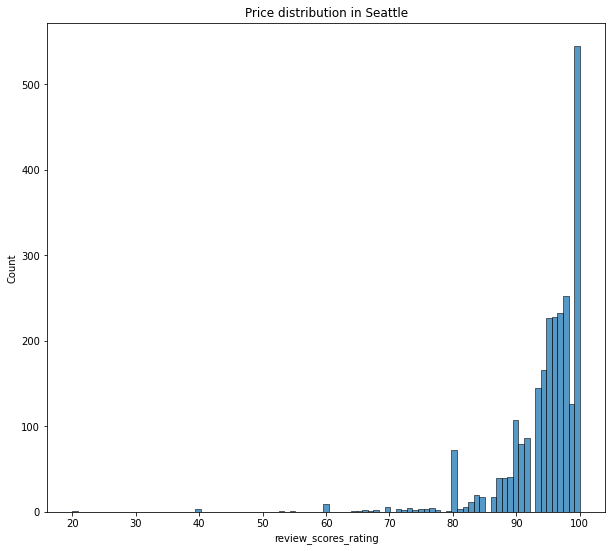

In [7]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Seattle')
ax = sns.histplot(df_listings_sea['review_scores_rating'])
df_listings_sea['review_scores_rating'].describe()

count    2312.000000
mean       91.957612
std         9.008718
min        20.000000
25%        89.000000
50%        94.000000
75%        98.000000
max       100.000000
Name: review_scores_rating, dtype: float64

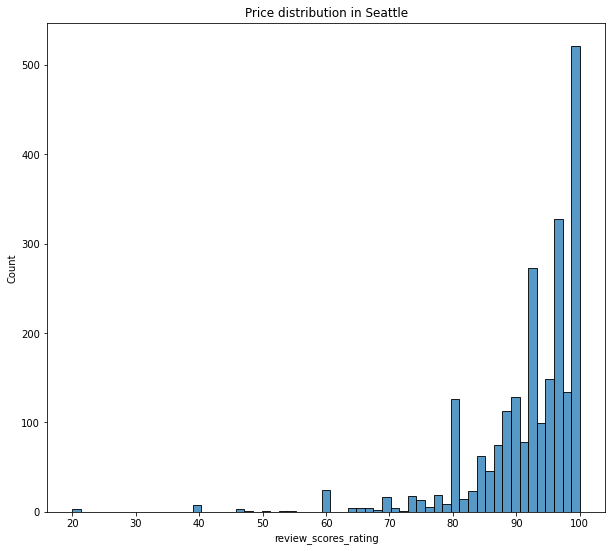

In [8]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Seattle')
ax = sns.histplot(df_listings_bos['review_scores_rating'])
df_listings_bos['review_scores_rating'].describe()

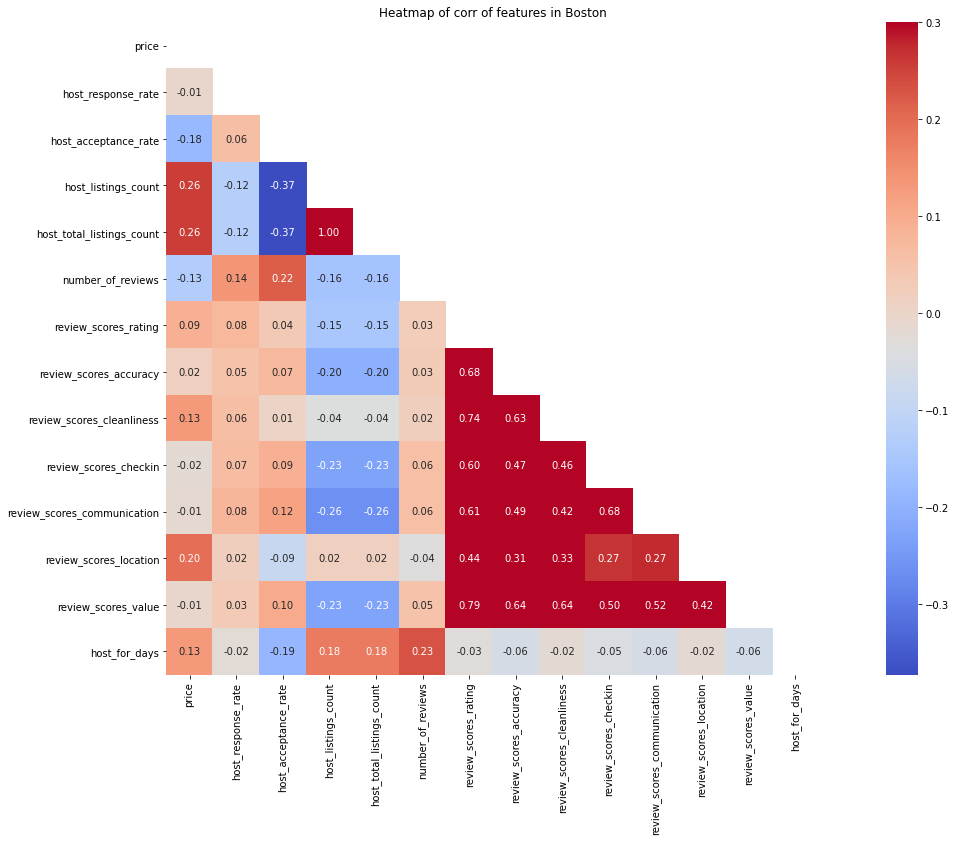

In [9]:
corr = df_listings_bos.select_dtypes(include=['int64', 'float64']).corr()
_mask = np.zeros_like(corr)
_mask[np.triu_indices_from(_mask)] = True
plt.figure(figsize=(24,12))
plt.title('Heatmap of corr of features in Boston')
sns.heatmap(corr, mask = _mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

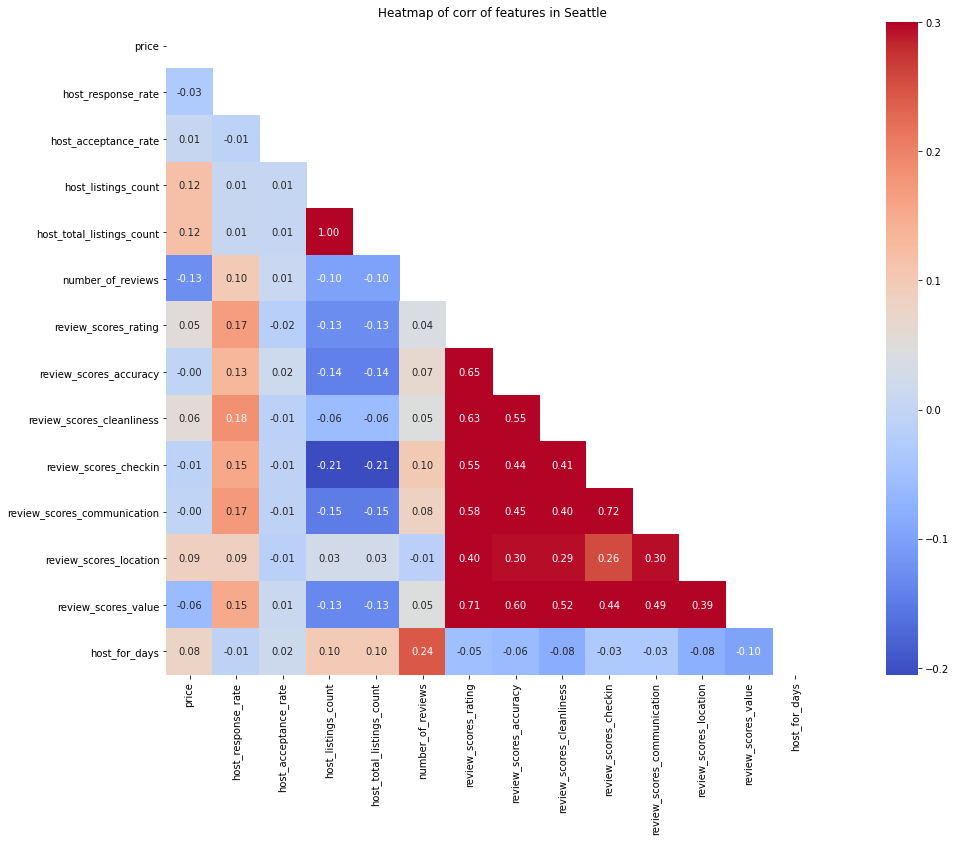

In [10]:
corr = df_listings_sea.select_dtypes(include=['int64', 'float64']).corr()
_mask = np.zeros_like(corr)
_mask[np.triu_indices_from(_mask)] = True
plt.figure(figsize=(24,12))
plt.title('Heatmap of corr of features in Seattle')
sns.heatmap(corr, mask = _mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

## host_response_time

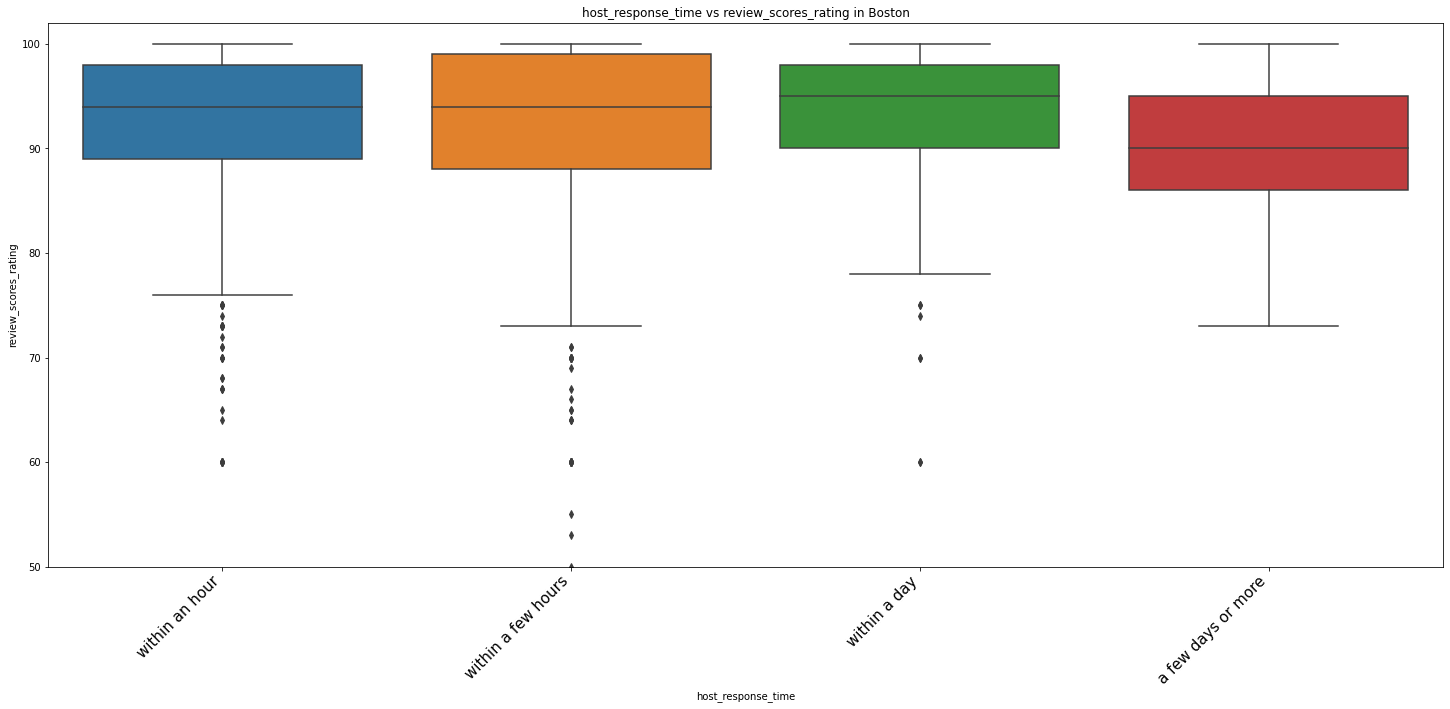

In [11]:
plt.figure(figsize=(25,10))
plt.title("host_response_time vs review_scores_rating in Boston")

sns.boxplot(data=df_listings_bos, x='host_response_time', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([50,102])
plt.show()

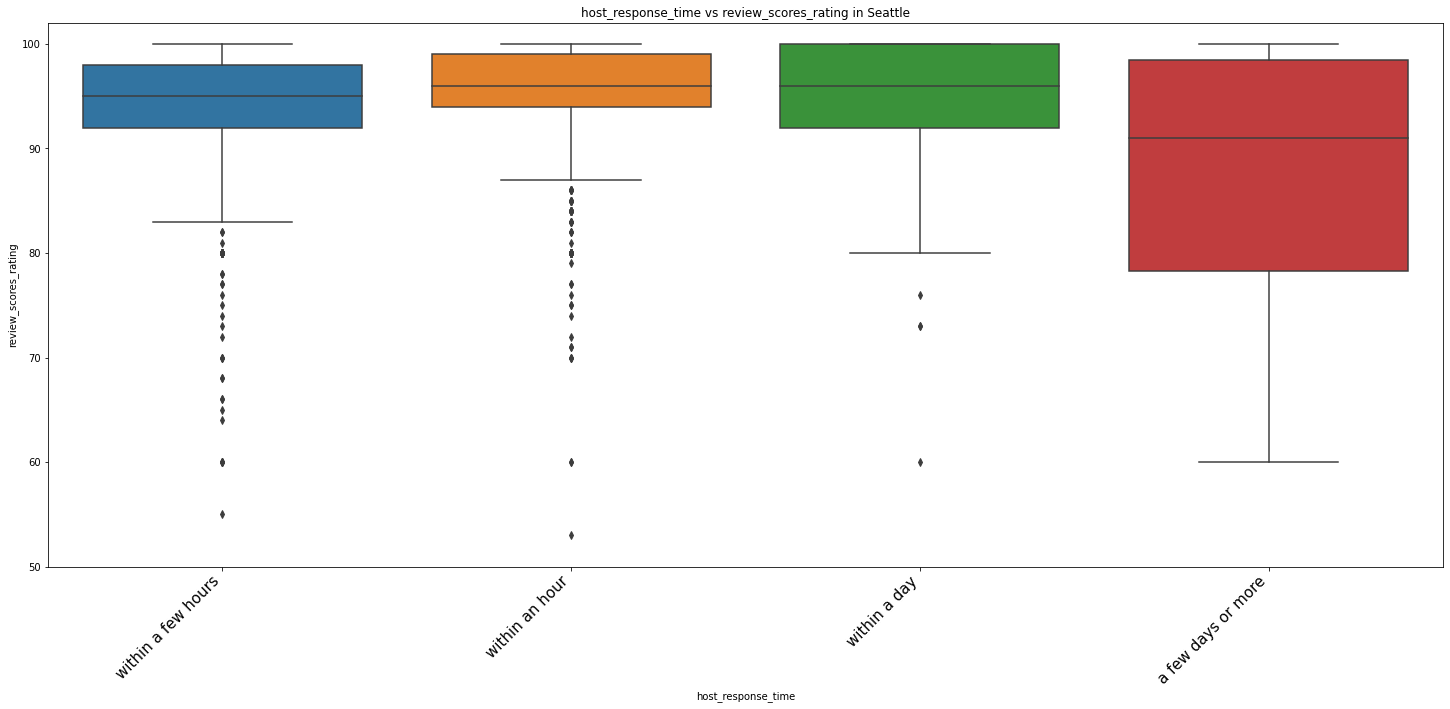

In [12]:
plt.figure(figsize=(25,10))
plt.title("host_response_time vs review_scores_rating in Seattle")

sns.boxplot(data=df_listings_sea, x='host_response_time', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([50,102])
plt.show()

## host_is_superhost

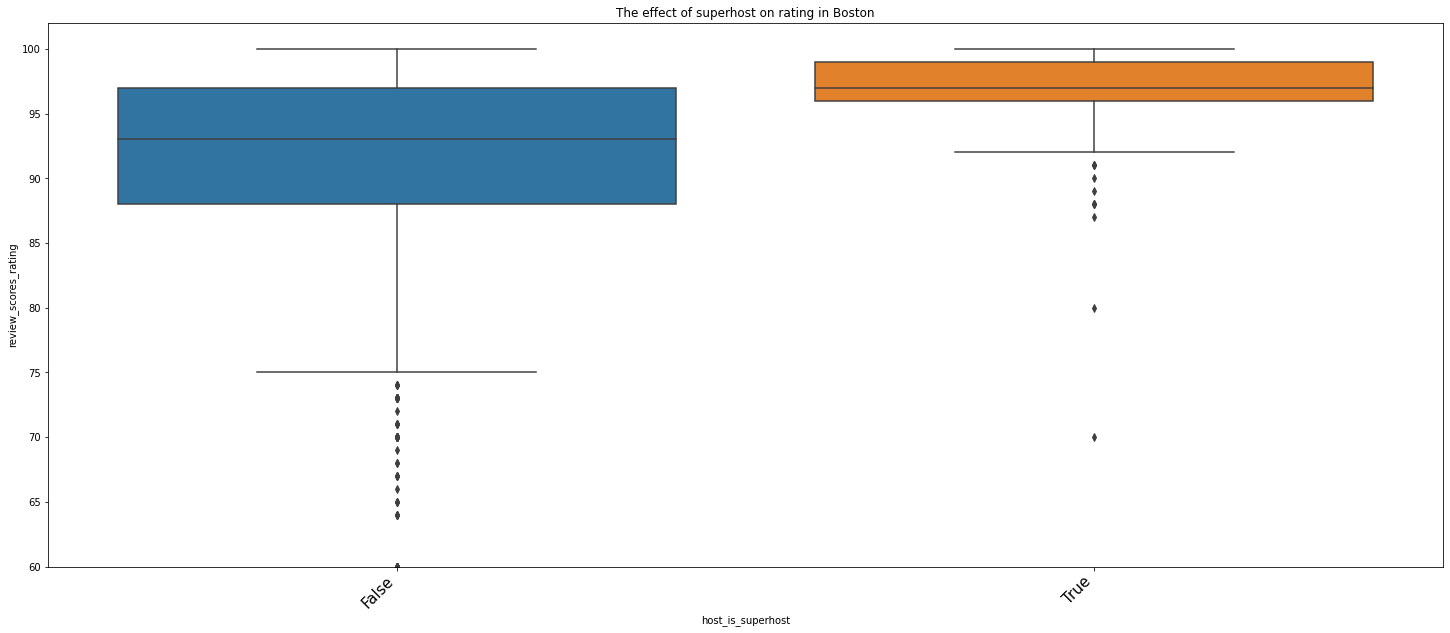

In [13]:
plt.figure(figsize=(25,10))
plt.title("The effect of superhost on rating in Boston")

sns.boxplot(data=df_listings_bos, x='host_is_superhost', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()

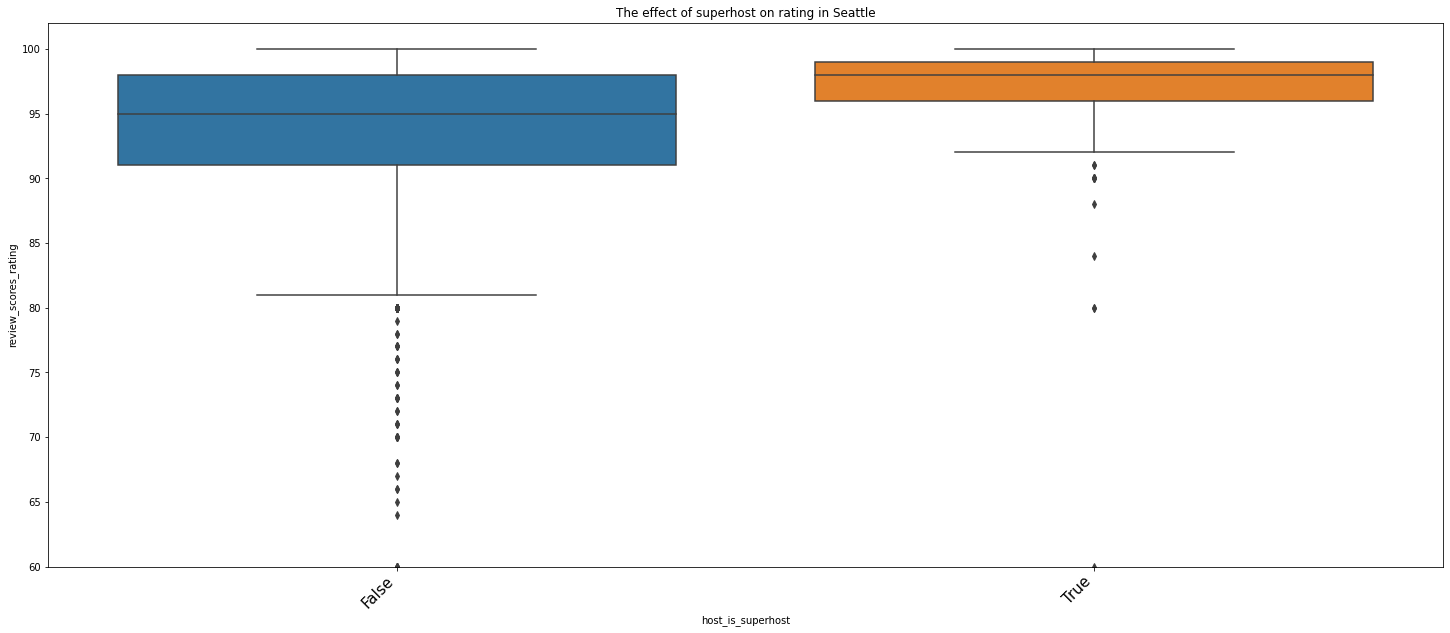

In [14]:
plt.figure(figsize=(25,10))
plt.title("The effect of superhost on rating in Seattle")

sns.boxplot(data=df_listings_sea, x='host_is_superhost', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()

## host_has_profile_pic

In [15]:
df_listings_bos.host_has_profile_pic.value_counts()

True     2307
False       5
Name: host_has_profile_pic, dtype: int64

In [16]:
df_listings_sea.host_has_profile_pic.value_counts()

True     2514
False       3
Name: host_has_profile_pic, dtype: int64

## host_identity_verified

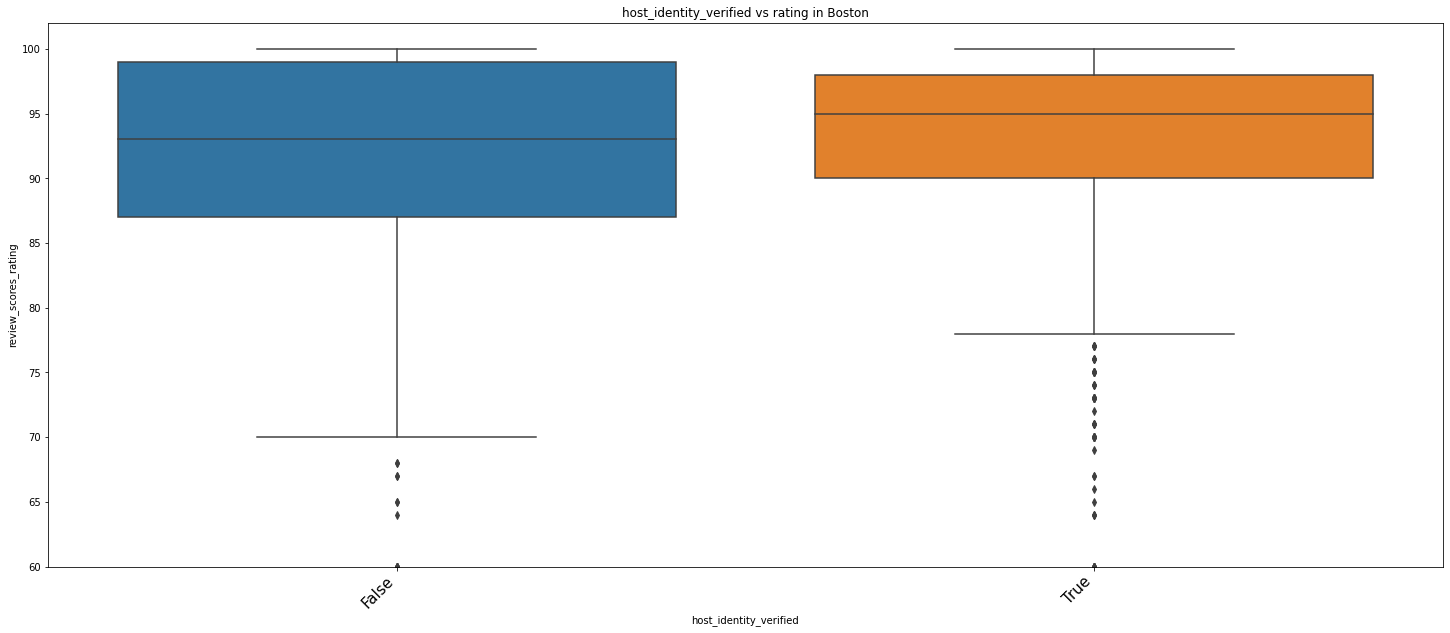

In [17]:
plt.figure(figsize=(25,10))
plt.title("host_identity_verified vs rating in Boston")

sns.boxplot(data=df_listings_bos, x='host_identity_verified', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()

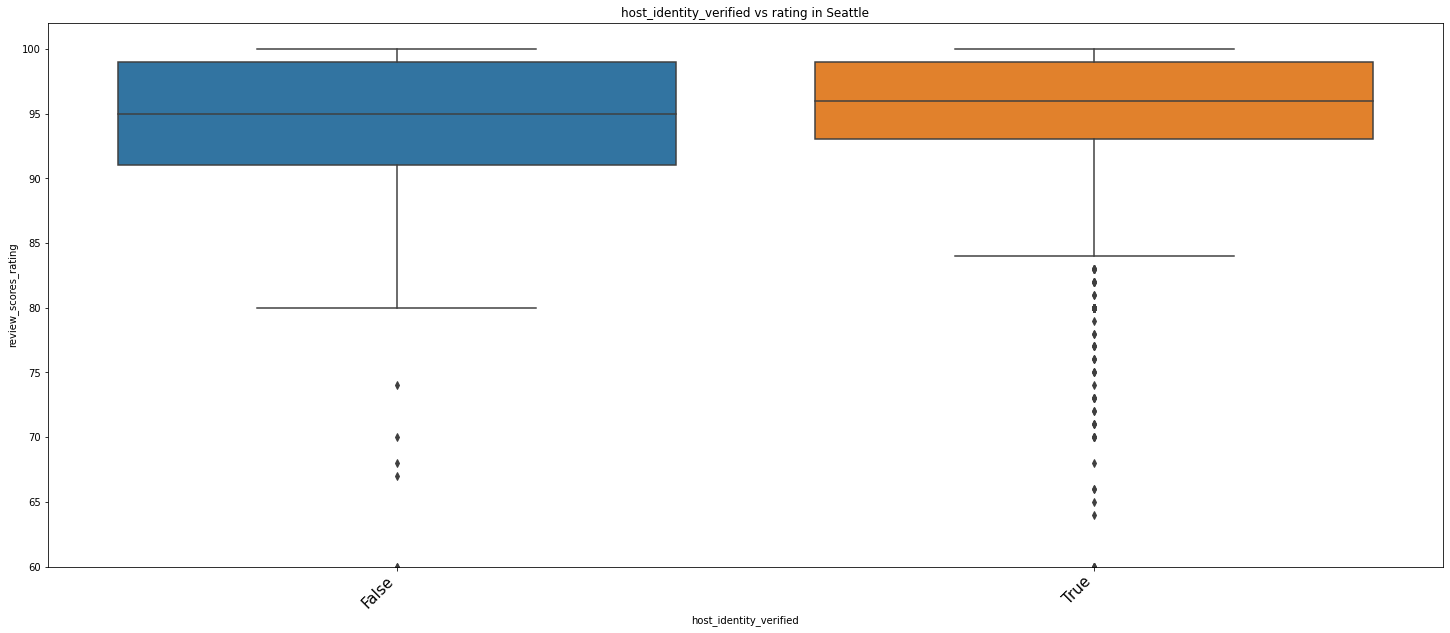

In [18]:
plt.figure(figsize=(25,10))
plt.title("host_identity_verified vs rating in Seattle")

sns.boxplot(data=df_listings_sea, x='host_identity_verified', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()

## host_about_exist

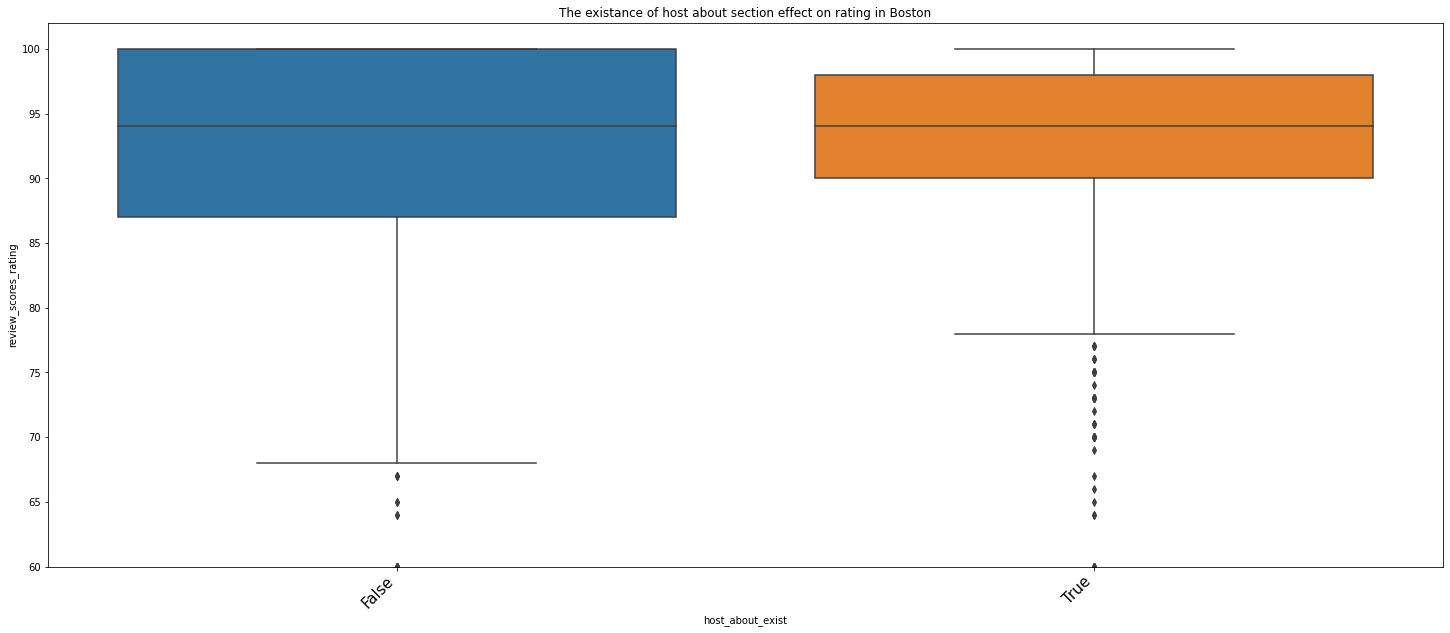

In [19]:
plt.figure(figsize=(25,10))
plt.title("The existance of host about section effect on rating in Boston")

sns.boxplot(data=df_listings_bos, x='host_about_exist', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()

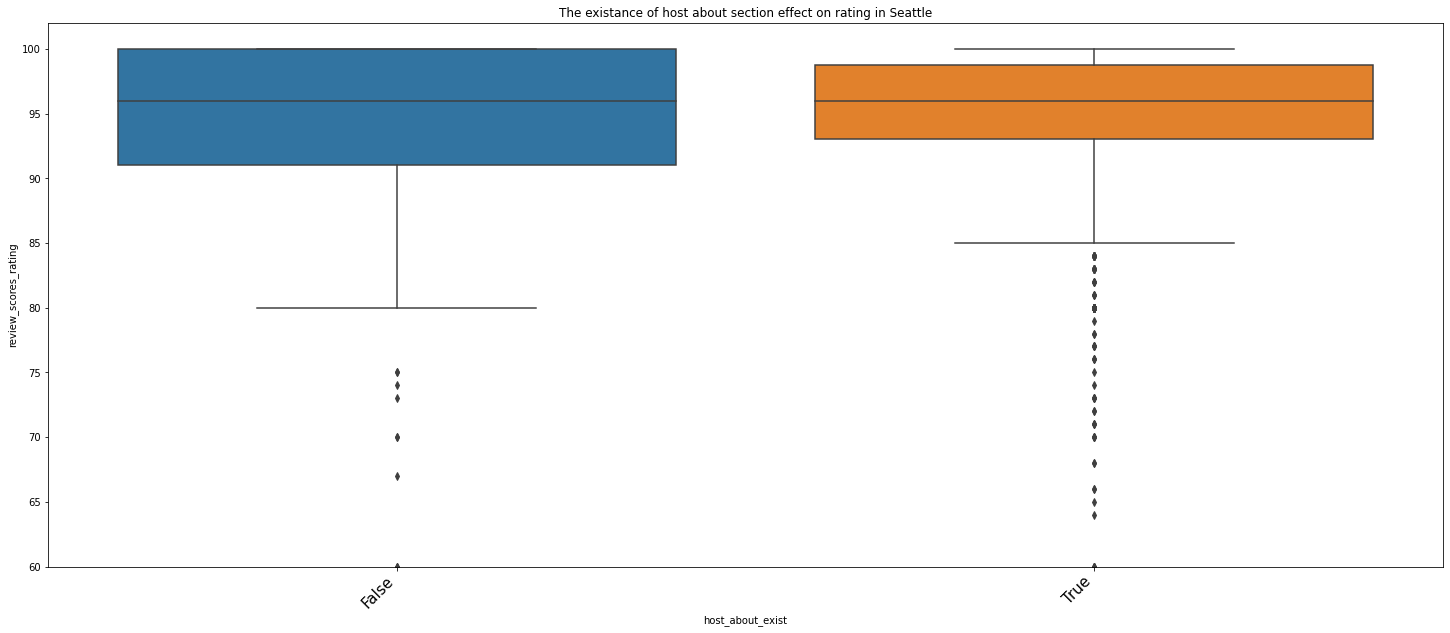

In [20]:
plt.figure(figsize=(25,10))
plt.title("The existance of host about section effect on rating in Seattle")

sns.boxplot(data=df_listings_sea, x='host_about_exist', y='review_scores_rating')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([60,102])
plt.show()